In [101]:
# Warnings ignoring
import warnings
warnings.filterwarnings("ignore")

# OS tools
from pathlib import Path
from dataclasses import dataclass
from collections import Counter

# Tables, arrays, and plotters 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch

# Video Processing
import cv2
from torchvision.io import read_video

In [39]:
def grid(ax) -> None:
    ax.minorticks_on()
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')

In [59]:
@dataclass
class FilePaths:
    base = Path("../data/UCF101")
    train = Path("../data/UCF101/train.csv")
    test = Path("../data/UCF101/test.csv")
    val = Path("../data/UCF101/val.csv")

In [8]:
df_train = pd.read_csv(FilePaths.train)
df_test = pd.read_csv(FilePaths.train)
df_val = pd.read_csv(FilePaths.val)

df_train.head()

,clip_name,clip_path,label
0,v_Swing_g05_c02,/train/Swing/v_Swing_g05_c02.avi,Swing
1,v_Swing_g21_c03,/train/Swing/v_Swing_g21_c03.avi,Swing
2,v_Swing_g07_c01,/train/Swing/v_Swing_g07_c01.avi,Swing
3,v_Swing_g24_c04,/train/Swing/v_Swing_g24_c04.avi,Swing
4,v_Swing_g20_c03,/train/Swing/v_Swing_g20_c03.avi,Swing


In [13]:
labels_total = Counter(df_train["label"].tolist() + df_test["label"].tolist() + df_val["label"].tolist())
labels_train = Counter(df_train["label"].tolist())
labels_test = Counter(df_test["label"].tolist())
labels_val = Counter(df_val["label"].tolist())

In [111]:
len(labels_total.keys()), len(labels_train.keys()), len(labels_test.keys()), len(labels_val.keys())

(101, 101, 101, 101)

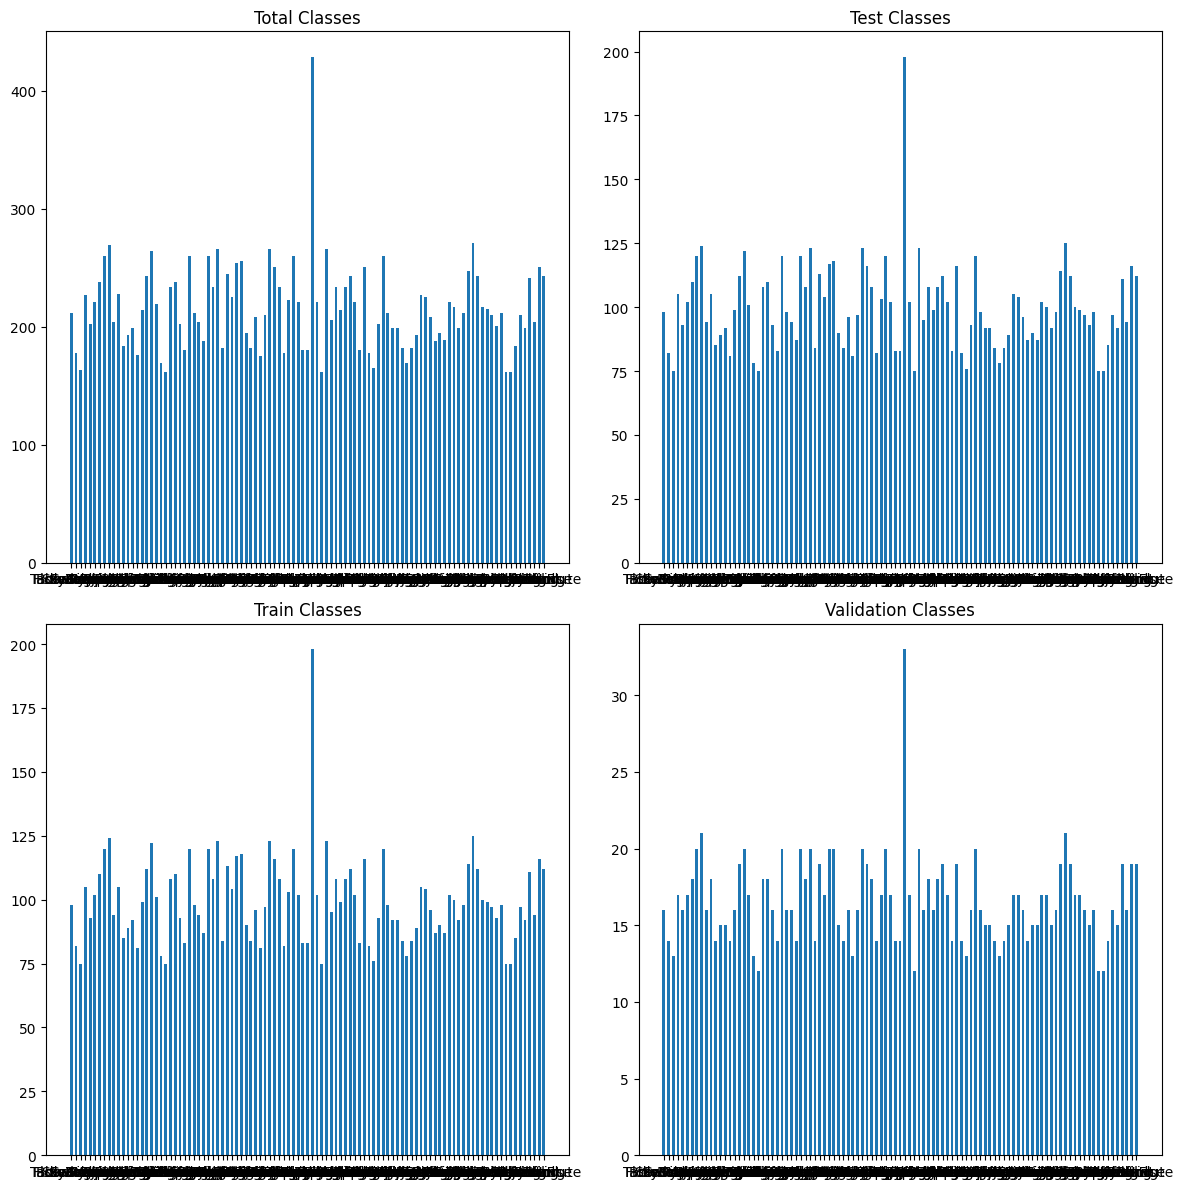

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0][0].set_title("Total Classes")
axes[0][0].bar(labels_total.keys(), labels_total.values(), width=0.6)

axes[1][0].set_title("Train Classes")
axes[1][0].bar(labels_train.keys(), labels_train.values(), width=0.6)

axes[0][1].set_title("Test Classes")
axes[0][1].bar(labels_test.keys(), labels_test.values(), width=0.6)

axes[1][1].set_title("Validation Classes")
axes[1][1].bar(labels_val.keys(), labels_val.values(), width=0.6)

plt.tight_layout()
plt.show()


In [93]:
%%timeit
frames, _, info = read_video(f"{FilePaths.base}{df_train['clip_path'].iloc[1]}", output_format="TCHW")
frames.shape[0]

37.1 ms ± 318 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
%%timeit
cap = cv2.VideoCapture(f"{FilePaths.base}{df_train['clip_path'].iloc[1]}")
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()
frame_count

759 μs ± 42.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [96]:
paths = df_train['clip_path'].tolist() + df_test['clip_path'].tolist() + df_val['clip_path'].tolist()
len(paths)

21783

In [97]:
counts = []
for path in paths:
    cap = cv2.VideoCapture(f"{FilePaths.base}{path}")
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    counts.append(frame_count)

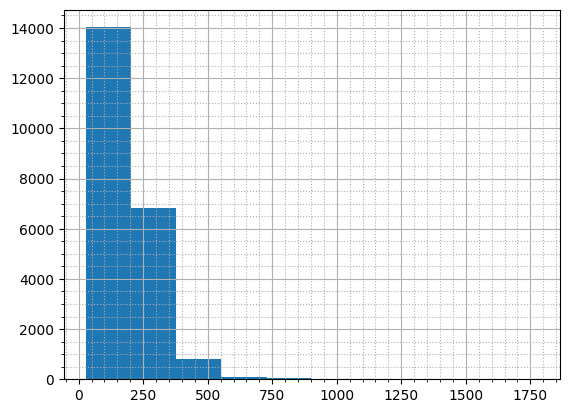

In [98]:
plt.hist(counts)
grid(plt)
plt.show()

In [99]:
min(counts), max(counts)

(29, 1776)

In [100]:
sorted(counts)[:10]

[29, 29, 30, 30, 30, 30, 34, 34, 35, 35]

In [102]:
def video_to_tensor(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR (OpenCV) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0

        # Convert to tensor and permute to (C, H, W)
        tensor = torch.from_numpy(frame).permute(2, 0, 1)
        frames.append(tensor)

    cap.release()

    # Stack all frames to get shape (T, C, H, W)
    video_tensor = torch.stack(frames)
    return video_tensor

In [104]:
r_videos = np.random.choice(paths, 100)

In [108]:
%%timeit
for path in r_videos:
    read_video(f"{FilePaths.base}{path}")

5.74 s ± 79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit
for path in r_videos:
    video_to_tensor(f"{FilePaths.base}{path}")

8.43 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
read_video